In [53]:
import pandas as pd
import re

import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

#nltk stopwords
from nltk.corpus import stopwords

# Plotting tools
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Read Posts

In [2]:
name = "LatinosForTrump"
terms = "trump|republicans|republican"
posts1 = pd.read_csv(name+"1.csv")
posts2 = pd.read_csv(name+"2.csv")
candidate = pd.concat([posts1,posts2],axis=0)
candidate.head(2)

,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )
0,#WalkAway Campaign,NaN,1945356878817544,473251.0,2020-09-20 10:14:06 EDT,Photo,17315,21844,2248,9780,...,Update: We've been overwhelmed with love and s...,https://www.facebook.com/photo.php?fbid=101592...,NaN,NaN,NaN,NaN,NaN,NaN,"87,280","87,280"
1,#WalkAway Campaign,NaN,1945356878817544,403749.0,2020-08-28 19:09:31 EDT,Photo,14404,2267,1666,7915,...,My husband was in California this week on busi...,https://www.facebook.com/photo.php?fbid=101021...,NaN,NaN,NaN,NaN,NaN,NaN,"26,518","26,518"


In [3]:
candidate.columns

Index(['Group Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )'],
      dtype='object')

## Filter the most relevant columns

In [4]:
content = candidate[['Message','Description','Link','Group Name','Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care','Total Interactions']].copy()
content.shape

(17007, 14)

### Add column to concat Message and Description

In [5]:
concat_message = content['Message'].fillna('') + (' ' + content['Description']).fillna('')
content['MessageDescr'] = concat_message

### Just keep those groups that have Trump or Republican in their name

In [6]:
groups_candidate = content['Group Name'].str.lower().reset_index()
final_groups = groups_candidate[groups_candidate['Group Name'].str.contains(terms)].copy()
final_groups = final_groups['Group Name'].unique()
final_groups = pd.DataFrame(final_groups)
final_groups.columns = ['Group Name']
final_groups.to_csv(name+"_groups.csv")
final_groups.shape

(1394, 1)

In [7]:
content['Group Name'] = content['Group Name'].str.lower()
content.shape

(17007, 15)

### Keep the posts from the preselected groups

In [8]:
content = content[content['Group Name'].isin(final_groups['Group Name'])].copy()
content.shape

(6525, 15)

## Tokenize words and Clean-up text

In [9]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(6525,)

In [10]:
# Convert to list
data = content.cleanMessage.tolist()

In [11]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['latinos', 'for', 'trump', 'midland', 'texas']]


#### Creating Bigram and Trigram Models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['latinos', 'for', 'trump', 'midland', 'texas']


In [14]:
stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('spanish'))
stop_words.extend(['su','sus','al','de','en','el'])
stop_words.extend(['like','would','get','many','much'])

## Remove Stopwords, Make Bigrams and Lemmatize

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts,stop_words_lang):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_lang] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Bag of Words

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words,stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[[], ['parade', 'today']]


In [17]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        print(concat_name, dictionary[concat_name])
    return dictionary

In [18]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [19]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)

donald / trump 7592
joe / biden 531
kamala / harris 6
latino / latinos 3161
communism / communist 193


In [20]:
final_dict.most_common(1000)

[('donald / trump', 7592),
 ('latino / latinos', 3161),
 ('great', 1736),
 ('support', 1662),
 ('vote', 1633),
 ('people', 1499),
 ('roundtable', 1219),
 ('live', 1190),
 ('make', 1177),
 ('woman', 1164),
 ('time', 1068),
 ('know', 1038),
 ('president', 1011),
 ('say', 991),
 ('black', 916),
 ('night', 897),
 ('american', 879),
 ('hold', 867),
 ('watch', 865),
 ('flag', 845),
 ('love', 819),
 ('event', 804),
 ('want', 784),
 ('rally', 760),
 ('man', 741),
 ('go', 720),
 ('group', 716),
 ('see', 688),
 ('election', 671),
 ('world', 666),
 ('keep', 658),
 ('get', 658),
 ('line', 656),
 ('show', 654),
 ('medium', 642),
 ('host', 621),
 ('thousand', 613),
 ('voter', 606),
 ('today', 576),
 ('pray', 568),
 ('tell', 544),
 ('joe / biden', 531),
 ('text', 521),
 ('come', 520),
 ('good', 520),
 ('last', 516),
 ('first', 516),
 ('leave', 511),
 ('community', 509),
 ('even', 504),
 ('well', 499),
 ('honest', 481),
 ('country', 471),
 ('latinosfortrump', 450),
 ('back', 437),
 ('participant', 437

## TD-IDF

In [21]:
docs = ([' '.join(ele) for ele in data_words_nostops] )

In [22]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(6525, 12546)

In [23]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [24]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.170864
latinos,1.327594
president,1.752489
donald,2.261690
florida,2.563907
...,...
landed,9.090402
lancaster,9.090402
𝐯𝐨𝐭𝐞𝐬,9.090402
lauderdale,9.090402


In [25]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [26]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv(name+"_tfidf.csv")

In [27]:
df

,tfidf
latinos,0.137324
midland,0.845514
texas,0.501579
trump,0.121112


In [28]:
word = df.index[0]
content["lowercase"] = content['MessageDescr'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]

word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word +"_"+ name+"_messages.csv")
word_messages

,unique_messages,counts
0,live: president donald trump holds latinos fo...,237
1,watch live: president donald trump holds lati...,201
2,watch live: president trump hosts latinos for...,162
3,kamala harris stops by 2 florida\nrestaurants...,153
4,"president donald j. trump hosts a ""latinos fo...",129
...,...,...
1855,upcoming flag waving!! 🇺🇲🇺🇲 \nflag waving eve...,1
1856,wow‼️‼️‼️❤🤍💙🇺🇲🇺🇲🇺🇲 latinos in south florida lo...,1
1857,hispanic heritage month patriots support trump...,1
1858,come on latinos !!! the latino awakening! #lex...,1


### Repeated messages

In [33]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
#results = content.groupby(['MessageDescr']).aggregate({'Group Name':['count',' |'.join],'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
#       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results = content.groupby(['MessageDescr']).aggregate({'Group Name':'count','MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})


results.rename(columns={"MessageDescr": "Counts",'Group Name':"Groups"}, inplace=True)


results.to_csv("mostpopularLatinosFor"+name+".csv")

In [34]:
results.sort_values(by='Total Interactions',ascending=False)


,Groups,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,,,,,,,,,,,,
"Kamala Harris stops by 2 Florida\nrestaurants but was shocked, she was met by Latinos for Trump who oppose her socialism.\n(Spanish news)\n#latinosfortrump \n#lexit",153,153,4625,729,1859,1340,24,523,2,16,31,9149
"Latinos in South Florida love President Trump. Latinos from Nicaragua, Venezuela and Cuba living in South Florida know the dangers of Socialism and Communism which is why they reject Joe Biden and Kamala Harris. Thousands of cars participated in Saturday’s anti-Communist, Latinos for Trump caravan...",111,111,4357,452,2085,1634,102,4,1,1,22,8658
"https://www.thegatewaypundit.com/2020/10/miami-pd-estimates-30000-cars-participated-anti-communist-latinos-trump-caravan-south-florida-video/?utm_source=Twitter&utm_medium=PostTopSharingButtons&utm_campaign=websitesharingbuttons Latinos in South Florida love President Trump. Latinos from Nicaragua, Venezuela and Cuba living in South Florida know the dangers of Socialism and Communism which is why they reject Joe Biden and Kamala Harris. Thousands of cars participated in Saturday’s anti-Communist, Latinos for Trump caravan...",3,3,4022,493,2226,1684,119,10,0,1,25,8580
🚨 WATCH THIS 🚨\n\nTHOUSANDS of Hispanics gathered in Miami today for an anti-socialism caravan and concert in support of President Donald J. Trump.\n\nLatino enthusiasm for President Trump is very real—and it is growing!,134,134,1712,176,458,600,23,2,0,1,17,2989
"Miami PD Estimates More Than 30,000 Cars Participated in Anti-Communist, Latinos For Trump Caravan in South Florida (VIDEO)",10,10,1334,236,473,662,44,2,1,0,8,2760
...,...,...,...,...,...,...,...,...,...,...,...,...
Latinos in FL have #LEXIT the Democrat Plantation. \n\nLatinos for Trump | LEXIT,1,1,0,0,0,0,0,0,0,0,0,0
Let’s take a selfie! 🤳📸 #LatinosForTrump,1,1,0,0,0,0,0,0,0,0,0,0
"Event Info 👇🏻 TWO4TRUMP, PATRIOTS 4 TRUMP, COMMUNITY PATRIOTS, TAMPA BAY TRUMP SUPPORTERS, THE SOUTH TAMPA REPUBLICAN, SOUTH TAMPA REPUBLICAN CLUB AND LATINOS FOR TRUMP",1,1,0,0,0,0,0,0,0,0,0,0


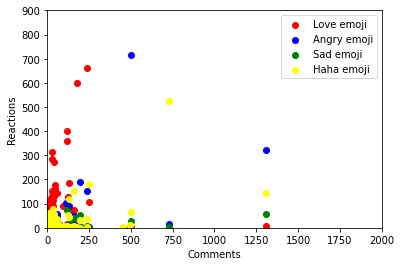

In [56]:
results.reset_index()
plt.xlim(0,2000)
plt.ylim(0,900)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')
plt.scatter(results.Comments, results.Haha,c='yellow',label='Haha emoji')
plt.legend()
